In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-timeseries-jetrail-traffic-forecasting/sample_submission.csv
/kaggle/input/av-timeseries-jetrail-traffic-forecasting/Train.csv
/kaggle/input/av-timeseries-jetrail-traffic-forecasting/Test.csv


In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
!ls -l /kaggle/input/
!pwd

total 0
drwxr-xr-x 2 nobody nogroup 0 Sep 11 13:47 av-timeseries-jetrail-traffic-forecasting
/kaggle/working


In [4]:
train = pd.read_csv('/kaggle/input/av-timeseries-jetrail-traffic-forecasting/Train.csv',parse_dates=['Datetime'],dayfirst=True,infer_datetime_format=True)
test = pd.read_csv('/kaggle/input/av-timeseries-jetrail-traffic-forecasting/Test.csv',parse_dates=['Datetime'],dayfirst=True,infer_datetime_format=True)
submission = pd.read_csv('/kaggle/input/av-timeseries-jetrail-traffic-forecasting/sample_submission.csv',dayfirst=True)

In [5]:
#train[]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


In [7]:
display(train.head(), train.tail())

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


,ID,Datetime,Count
18283,18283,2014-09-25 19:00:00,868
18284,18284,2014-09-25 20:00:00,732
18285,18285,2014-09-25 21:00:00,702
18286,18286,2014-09-25 22:00:00,580
18287,18287,2014-09-25 23:00:00,534


In [8]:
display(train.iloc[200])

ID                          200
Datetime    2012-09-02 08:00:00
Count                         4
Name: 200, dtype: object

In [9]:
display(test.head(), test.tail())

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00


,ID,Datetime
5107,23395,2015-04-26 19:00:00
5108,23396,2015-04-26 20:00:00
5109,23397,2015-04-26 21:00:00
5110,23398,2015-04-26 22:00:00
5111,23399,2015-04-26 23:00:00


In [10]:
display(submission.head(), submission.tail())

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


,ID,Count
5107,23395,0
5108,23396,0
5109,23397,0
5110,23398,0
5111,23399,0


In [11]:
display(train.describe().T, test.describe().T, submission.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,18288.0,9143.500000,5279.435197,0.0,4571.75,9143.5,13715.25,18287.0
Count,18288.0,138.958115,153.467461,2.0,22.00,84.0,210.00,1244.0


,count,mean,std,min,25%,50%,75%,max
ID,5112.0,20843.5,1475.851619,18288.0,19565.75,20843.5,22121.25,23399.0


,count,mean,std,min,25%,50%,75%,max
ID,5112.0,20843.5,1475.851619,18288.0,19565.75,20843.5,22121.25,23399.0
Count,5112.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0


In [12]:
train.shape, test.shape, submission.shape

((18288, 3), (5112, 2), (5112, 2))

In [13]:
train.index, test.index, submission.index

(RangeIndex(start=0, stop=18288, step=1),
 RangeIndex(start=0, stop=5112, step=1),
 RangeIndex(start=0, stop=5112, step=1))

In [14]:
train.info(), test.info(), submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        5112 non-null   int64         
 1   Datetime  5112 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 80.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5112 non-null   int64
 1   Count   5112 non-null   int64
dtypes: i

(None, None, None)

In [15]:
train['Datetime'].duplicated().sum(), test['Datetime'].duplicated().sum()

(0, 0)

In [16]:
train.isna().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [17]:
train['Count'].value_counts()

2       602
4       512
6       496
10      452
8       440
       ... 
740       1
1068      1
1038      1
898       1
656       1
Name: Count, Length: 437, dtype: int64

<AxesSubplot:>

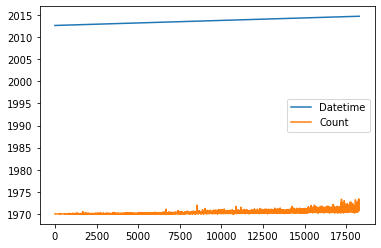

In [18]:
train.drop(columns='ID').plot()

In [19]:
data = train.copy()

<AxesSubplot:>

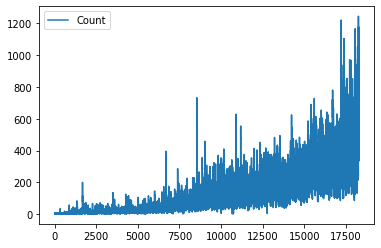

In [20]:
data.drop(columns=['ID','Datetime']).plot()

# FBProphet

In [21]:
model = Prophet()

In [22]:
rn_train = train.drop(columns='ID').copy()
rn_train.columns = ['ds','y']
rn_train.head()

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


In [23]:
rn_test = test.drop(columns='ID').copy()
rn_test.columns = ['ds']
rn_test.head()

,ds
0,2014-09-26 00:00:00
1,2014-09-26 01:00:00
2,2014-09-26 02:00:00
3,2014-09-26 03:00:00
4,2014-09-26 04:00:00


In [24]:
model.fit(rn_train)

Initial log joint probability = -165.451


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       43825.1     0.0194951       5981.41           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       43838.5    0.00240902       204.788           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       43843.5   1.03718e-05       62.8157   5.379e-08       0.001      391  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       43846.4    0.00327561       363.336           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       43847.2   1.25997e-05       98.0721   5.873e-08       0.001      606  LS failed, Hessian reset 
     456       43847.4   3.53412e-05       109.221   4.73

In [25]:
print(model.t_scale, model.y_scale)
#print(model.history_dates.to_csv('a2.csv'))
#print(model.history.to_csv('b2.csv'))

761 days 23:00:00 1244.0


In [26]:
print(1065/365)
print(365*3)
print(365*2*24)
print(365*2*24+32*24,'<--')
print('*'*10)
print(30*7*24)
print(30*7*24+(4-2+1)*24,'<--')

2.9178082191780823
1095
17520
18288 <--
**********
5040
5112 <--


In [27]:
train.shape, test.shape, submission.shape

((18288, 3), (5112, 2), (5112, 2))

In [28]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'daily',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [29]:
### Create future dates of 365 days
future_dates=model.make_future_dataframe(periods=3312, freq='H')

In [30]:
print(5112/24)
print(7*30*24+48+24)

213.0
5112


In [31]:
rn_train.isna().sum()

ds    0
y     0
dtype: int64

In [32]:
#new_future_dt = 
pd.date_range('2014-01-01', periods=10) + pd.Timedelta(days=1)

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11'],
              dtype='datetime64[ns]', freq='D')

In [33]:
future_dates=model.make_future_dataframe(periods=3312, freq='H')
display('train:',rn_train.head(), rn_train.tail(),
'new future:',future_dates.head(), future_dates.tail(),
'test:',test.head(), test.tail())

'train:'

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


,ds,y
18283,2014-09-25 19:00:00,868
18284,2014-09-25 20:00:00,732
18285,2014-09-25 21:00:00,702
18286,2014-09-25 22:00:00,580
18287,2014-09-25 23:00:00,534


'new future:'

,ds
0,2012-08-25 00:00:00
1,2012-08-25 01:00:00
2,2012-08-25 02:00:00
3,2012-08-25 03:00:00
4,2012-08-25 04:00:00


,ds
21595,2015-02-10 19:00:00
21596,2015-02-10 20:00:00
21597,2015-02-10 21:00:00
21598,2015-02-10 22:00:00
21599,2015-02-10 23:00:00


'test:'

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00


,ID,Datetime
5107,23395,2015-04-26 19:00:00
5108,23396,2015-04-26 20:00:00
5109,23397,2015-04-26 21:00:00
5110,23398,2015-04-26 22:00:00
5111,23399,2015-04-26 23:00:00


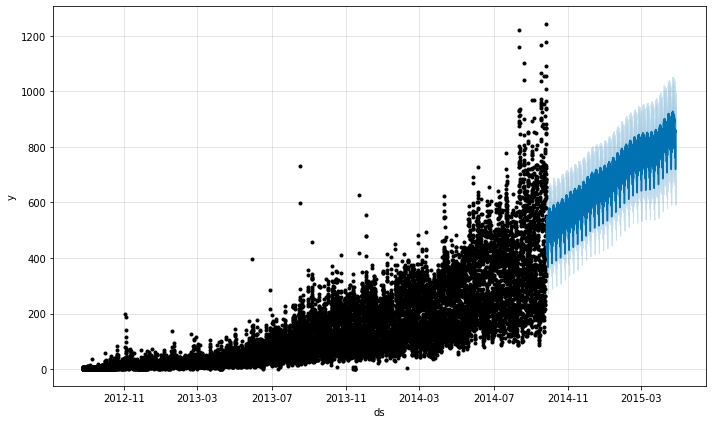

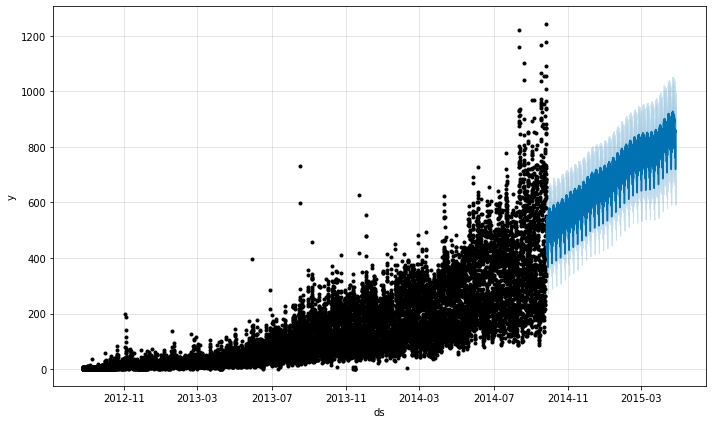

In [34]:
future_dates = rn_test.copy()
forecast = model.predict(future_dates)
model.plot(forecast)


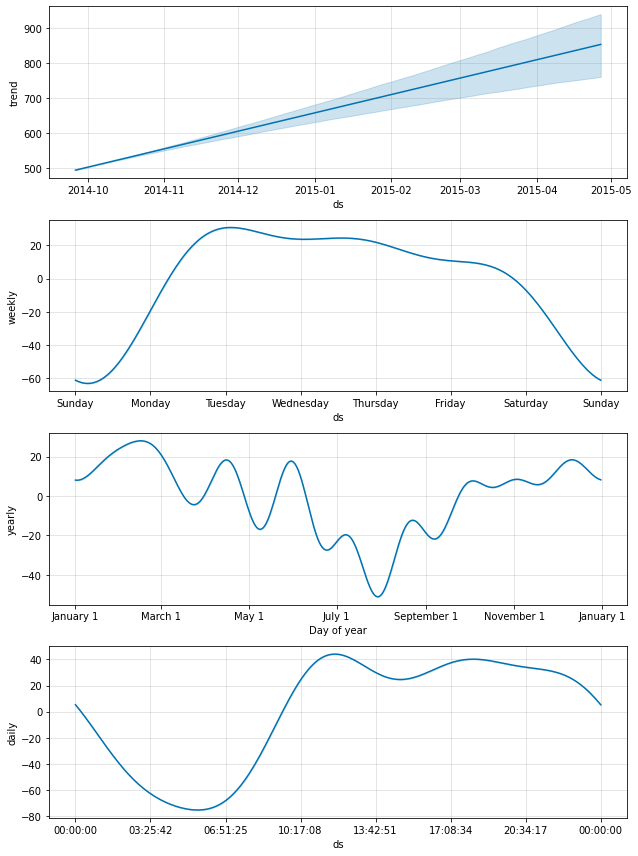

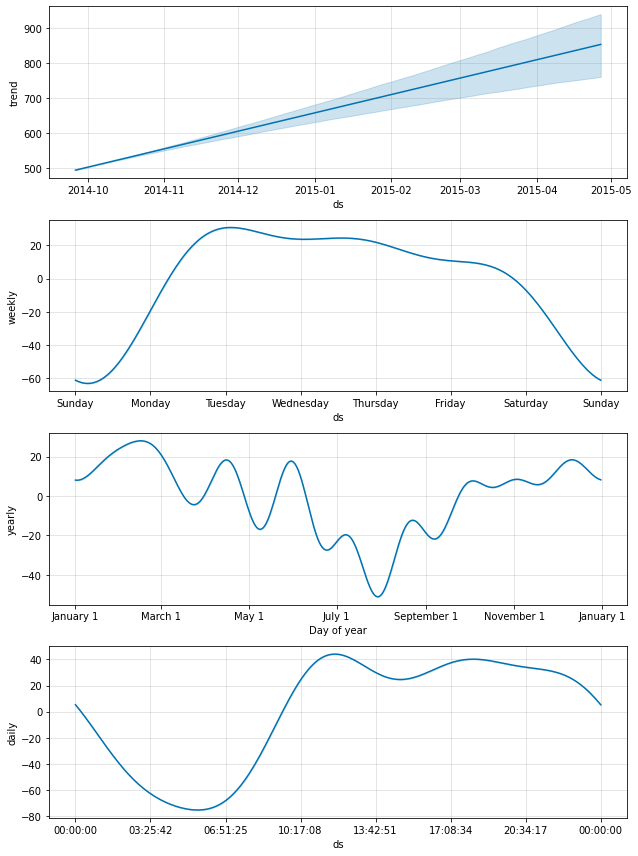

In [35]:
model.plot_components(forecast)

In [36]:
fcst = forecast[['ds','yhat']]#.tail(3961)
display(forecast)
print(fcst)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-26 00:00:00,494.107122,431.471529,599.608343,494.107122,494.107122,19.258472,19.258472,19.258472,5.315990,...,10.758383,10.758383,10.758383,3.184099,3.184099,3.184099,0.0,0.0,0.0,513.365594
1,2014-09-26 01:00:00,494.177200,404.434084,573.945046,494.177200,494.177200,-3.292500,-3.292500,-3.292500,-17.129440,...,10.602459,10.602459,10.602459,3.234480,3.234480,3.234480,0.0,0.0,0.0,490.884700
2,2014-09-26 02:00:00,494.247279,382.636837,559.413748,494.247279,494.247279,-25.977978,-25.977978,-25.977978,-39.721819,...,10.459251,10.459251,10.459251,3.284590,3.284590,3.284590,0.0,0.0,0.0,468.269300
3,2014-09-26 03:00:00,494.317357,359.052090,536.987888,494.317357,494.317357,-43.594465,-43.594465,-43.594465,-57.250478,...,10.321586,10.321586,10.321586,3.334427,3.334427,3.334427,0.0,0.0,0.0,450.722892
4,2014-09-26 04:00:00,494.387436,355.865648,525.633269,494.387436,494.387436,-54.787660,-54.787660,-54.787660,-68.353224,...,10.181572,10.181572,10.181572,3.383992,3.383992,3.383992,0.0,0.0,0.0,439.599775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2015-04-26 19:00:00,851.997977,725.947965,979.098250,759.839729,938.161508,6.721527,6.721527,6.721527,38.781610,...,-35.964457,-35.964457,-35.964457,3.904374,3.904374,3.904374,0.0,0.0,0.0,858.719504
5108,2015-04-26 20:00:00,852.068055,734.456393,982.214957,759.890126,938.246216,6.611695,6.611695,6.611695,35.532355,...,-32.727833,-32.727833,-32.727833,3.807174,3.807174,3.807174,0.0,0.0,0.0,858.679750
5109,2015-04-26 21:00:00,852.138134,730.714461,984.894914,759.941671,938.330924,7.356123,7.356123,7.356123,33.055645,...,-29.409374,-29.409374,-29.409374,3.709853,3.709853,3.709853,0.0,0.0,0.0,859.494257
5110,2015-04-26 22:00:00,852.208212,735.976510,994.532222,759.993216,938.415632,7.537024,7.537024,7.537024,29.954488,...,-26.029880,-26.029880,-26.029880,3.612415,3.612415,3.612415,0.0,0.0,0.0,859.745236


                      ds        yhat
0    2014-09-26 00:00:00  513.365594
1    2014-09-26 01:00:00  490.884700
2    2014-09-26 02:00:00  468.269300
3    2014-09-26 03:00:00  450.722892
4    2014-09-26 04:00:00  439.599775
...                  ...         ...
5107 2015-04-26 19:00:00  858.719504
5108 2015-04-26 20:00:00  858.679750
5109 2015-04-26 21:00:00  859.494257
5110 2015-04-26 22:00:00  859.745236
5111 2015-04-26 23:00:00  854.884099

[5112 rows x 2 columns]


In [37]:
forecast.ds.min(), forecast.ds.max()

(Timestamp('2014-09-26 00:00:00'), Timestamp('2015-04-26 23:00:00'))

In [38]:
submission['Count'] = forecast['yhat']
#submission.to_csv('submission_fb_v1.csv',index=False) #wrong dates
#383.540 Rnk#1066
#submission.to_csv('submission_fb_v2.csv',index=False) #corrected dates
#228.317 Rnk#604

# Linear Model

In [39]:
data = train.copy()
data['Source'] = 'Train'
display(data.head(),data.tail())

data = pd.concat([data,test])
data['Source'] = data['Source'].fillna('Test')

data["Datetime"] = pd.to_datetime(data["Datetime"], dayfirst=True)
data=data.sort_values(["Datetime"])
data["Quarter"] = data["Datetime"].dt.quarter
data["Year"] = data["Datetime"].dt.year
data["Month"] = data["Datetime"].dt.month
data["Day"] = data["Datetime"].dt.day
data["DayofWeek"] = data["Datetime"].dt.dayofweek
data["WeekofYear"] = data["Datetime"].dt.weekofyear
data["Hour"] = data["Datetime"].dt.hour
data["Minute"] = data["Datetime"].dt.minute
data[['Datetime','Day','DayofWeek','WeekofYear','Month','Quarter','Year','Hour','Minute']]
display(data.head(),data.tail())

,ID,Datetime,Count,Source
0,0,2012-08-25 00:00:00,8,Train
1,1,2012-08-25 01:00:00,2,Train
2,2,2012-08-25 02:00:00,6,Train
3,3,2012-08-25 03:00:00,2,Train
4,4,2012-08-25 04:00:00,2,Train


,ID,Datetime,Count,Source
18283,18283,2014-09-25 19:00:00,868,Train
18284,18284,2014-09-25 20:00:00,732,Train
18285,18285,2014-09-25 21:00:00,702,Train
18286,18286,2014-09-25 22:00:00,580,Train
18287,18287,2014-09-25 23:00:00,534,Train


,ID,Datetime,Count,Source,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour,Minute
0,0,2012-08-25 00:00:00,8.0,Train,3,2012,8,25,5,34,0,0
1,1,2012-08-25 01:00:00,2.0,Train,3,2012,8,25,5,34,1,0
2,2,2012-08-25 02:00:00,6.0,Train,3,2012,8,25,5,34,2,0
3,3,2012-08-25 03:00:00,2.0,Train,3,2012,8,25,5,34,3,0
4,4,2012-08-25 04:00:00,2.0,Train,3,2012,8,25,5,34,4,0


,ID,Datetime,Count,Source,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour,Minute
5107,23395,2015-04-26 19:00:00,NaN,Test,2,2015,4,26,6,17,19,0
5108,23396,2015-04-26 20:00:00,NaN,Test,2,2015,4,26,6,17,20,0
5109,23397,2015-04-26 21:00:00,NaN,Test,2,2015,4,26,6,17,21,0
5110,23398,2015-04-26 22:00:00,NaN,Test,2,2015,4,26,6,17,22,0
5111,23399,2015-04-26 23:00:00,NaN,Test,2,2015,4,26,6,17,23,0


In [40]:
#train['Minute'].notna().sum()

In [41]:
#train[train['Minute']==0]['Minute'].sum()
#display(data[['Minute','Quarter','Year','Month','Day','DayofWeek','WeekofYear','Hour']].value_counts())

#print(train.Quarter.value_counts().sort_index())
train = data[data['Source']=='Train']
test = data[data['Source']=='Test']
display(train.Minute.value_counts().sort_index(),
train.Quarter.value_counts().sort_index(),
train.Year.value_counts().sort_index(),     
train.Month.value_counts().sort_index(),
train.Day.value_counts().sort_index(),
train.DayofWeek.value_counts().sort_index(),
train.WeekofYear.value_counts().sort_index(),
train.Hour.value_counts().sort_index()      
     )



0    18288
Name: Minute, dtype: int64

1    4320
2    4368
3    5184
4    4416
Name: Quarter, dtype: int64

2012    3096
2013    8760
2014    6432
Name: Year, dtype: int64

1     1488
2     1344
3     1488
4     1440
5     1488
6     1440
7     1488
8     1656
9     2040
10    1488
11    1440
12    1488
Name: Month, dtype: int64

1     600
2     600
3     600
4     600
5     600
6     600
7     600
8     600
9     600
10    600
11    600
12    600
13    600
14    600
15    600
16    600
17    600
18    600
19    600
20    600
21    600
22    600
23    600
24    600
25    624
26    600
27    600
28    600
29    552
30    552
31    360
Name: Day, dtype: int64

0    2616
1    2616
2    2616
3    2616
4    2592
5    2616
6    2616
Name: DayofWeek, dtype: int64

1     336
2     336
3     336
4     336
5     336
6     336
7     336
8     336
9     336
10    336
11    336
12    336
13    336
14    336
15    336
16    336
17    336
18    336
19    336
20    336
21    336
22    336
23    336
24    336
25    336
26    336
27    336
28    336
29    336
30    336
31    336
32    336
33    336
34    384
35    504
36    504
37    504
38    504
39    432
40    336
41    336
42    336
43    336
44    336
45    336
46    336
47    336
48    336
49    336
50    336
51    336
52    336
Name: WeekofYear, dtype: int64

0     762
1     762
2     762
3     762
4     762
5     762
6     762
7     762
8     762
9     762
10    762
11    762
12    762
13    762
14    762
15    762
16    762
17    762
18    762
19    762
20    762
21    762
22    762
23    762
Name: Hour, dtype: int64

In [42]:
train = data[data['Source']=='Train']
test = data[data['Source']=='Test']

model = LinearRegression()
train_X = train.drop(columns = ['ID','Datetime','Count','Minute','Source'])
train_y = train['Count']
display(train_X.head(),train_y.head())

model.fit(train_X,train_y)
print('Score:',model.score(train_X,train_y))
print(mean_squared_error(train_y,model.predict(train_X),squared=False))


,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour
0,3,2012,8,25,5,34,0
1,3,2012,8,25,5,34,1
2,3,2012,8,25,5,34,2
3,3,2012,8,25,5,34,3
4,3,2012,8,25,5,34,4


0    8.0
1    2.0
2    6.0
3    2.0
4    2.0
Name: Count, dtype: float64

Score: 0.6862849984674747
85.95518463512508


In [43]:
ss = StandardScaler()
cols = train_X.columns
print(cols)
ss_train_X = pd.DataFrame(ss.fit_transform(train_X[cols]),columns=cols)
display(ss_train_X)

model.fit(ss_train_X,train_y)
print('Score:',model.score(ss_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(ss_train_X),squared=False))

Index(['Quarter', 'Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear', 'Hour'], dtype='object')


,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour
0,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.661325
1,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.516862
2,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.372399
3,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.227936
4,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.083473
...,...,...,...,...,...,...,...
18283,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.083473
18284,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.227936
18285,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.372399
18286,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.516862


Score: 0.6862849984674739
RMSE: 85.95518463512518


In [44]:
ms = MinMaxScaler()
cols = train_X.columns
print(cols)
ms_train_X = pd.DataFrame(ss.fit_transform(train_X[cols]),columns=cols)
display(ms_train_X)

model.fit(ms_train_X,train_y)
print('Score:',model.score(ms_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(ms_train_X),squared=False))

Index(['Quarter', 'Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear', 'Hour'], dtype='object')


,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour
0,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.661325
1,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.516862
2,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.372399
3,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.227936
4,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.083473
...,...,...,...,...,...,...,...
18283,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.083473
18284,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.227936
18285,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.372399
18286,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.516862


Score: 0.6862849984674739
RMSE: 85.95518463512518


In [45]:
rs = RobustScaler()
cols = train_X.columns
print(cols)
rs_train_X = pd.DataFrame(ss.fit_transform(train_X[cols]),columns=cols)
display(rs_train_X)

model.fit(rs_train_X,train_y)
print('Score:',model.score(rs_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(rs_train_X),squared=False))

Index(['Quarter', 'Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear', 'Hour'], dtype='object')


,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour
0,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.661325
1,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.516862
2,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.372399
3,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.227936
4,0.428085,-1.693104,0.404962,1.051435,1.000164,0.475468,-1.083473
...,...,...,...,...,...,...,...
18283,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.083473
18284,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.227936
18285,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.372399
18286,0.428085,1.170703,0.698569,1.051435,0.000656,0.812811,1.516862


Score: 0.6862849984674739
RMSE: 85.95518463512518


In [46]:

#ohe = OneHotEncoder()
#ohe_train_X = ohe.fit_transform(train_X).toarray()
#display(ohe_train_X)
cols = train_X.columns
print(cols)
gd_train_X = pd.get_dummies(train_X[cols].astype('O'))
display(gd_train_X.shape,gd_train_X)

model.fit(gd_train_X,train_y)
print('Score:',model.score(gd_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(gd_train_X),squared=False))

Index(['Quarter', 'Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear', 'Hour'], dtype='object')


(18288, 133)

,Quarter_1,Quarter_2,Quarter_3,Quarter_4,Year_2012,Year_2013,Year_2014,Month_1,Month_2,Month_3,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18284,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18285,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18286,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Score: 0.7766873062578025
RMSE: 72.52055838221793


In [47]:
train_X = train[['Year','Month','Day','Hour']] #.drop(columns = ['ID','Datetime','Count','Minute','Source'])
train_y = train[['Count']]
cols = train_X.columns
print(cols)
gd_train_X = pd.get_dummies(train_X[cols].astype('O'))
display(gd_train_X.shape,gd_train_X)

model.fit(gd_train_X,train_y)
print('Score:',model.score(gd_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(gd_train_X),squared=False))

Index(['Year', 'Month', 'Day', 'Hour'], dtype='object')


(18288, 70)

,Year_2012,Year_2013,Year_2014,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18284,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18285,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18286,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Score: 0.7329529330701239
RMSE: 79.30459294975613


In [48]:
data_X = data.drop(columns=['ID','Count','Datetime','Minute'])
cols = data_X.columns
print(cols)
gddt_data_X = pd.get_dummies(data[cols].astype('O'), drop_first=True)
#display(gddt_data_X.shape,gddt_data_X.columns)

gddt_train_X = gddt_data_X[gddt_data_X['Source_Train']==1]
gddt_test_X = gddt_data_X[gddt_data_X['Source_Train']==0]

gddt_train_X =  gddt_train_X.drop(columns = ['Source_Train'])
display(gddt_train_X.shape,gddt_train_X)


model.fit(gddt_train_X,train_y)
print('Score:',model.score(gddt_train_X,train_y))
print('RMSE:',mean_squared_error(train_y,model.predict(gddt_train_X),squared=False))

#test_X = test.drop(columns = ['ID','Count','Datetime','Minute','Source'])
#cols = train_X.columns
#print(cols)
#gddt_test_X = pd.get_dummies(test_X[cols].astype('O'), drop_first=True)
print('Test\n','*'*15)
gddt_test_X =  gddt_test_X.drop(columns = ['Source_Train'])
display(gddt_test_X.shape,gddt_test_X)
print(gddt_test_X.columns)
pred_test_y = model.predict(gddt_test_X)

submission['Count'] = pred_test_y
#submission.to_csv('submission_lr_gddt_v1.csv', index=False) # wrong dates
#317.592 Rnk#958
#submission.to_csv('submission_lr_gddt_v2.csv', index=False) # corrected dates

Index(['Source', 'Quarter', 'Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear',
       'Hour'],
      dtype='object')


(18288, 127)

,Quarter_2,Quarter_3,Quarter_4,Year_2013,Year_2014,Year_2015,Month_2,Month_3,Month_4,Month_5,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18284,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18285,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18286,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Score: 0.7767870217879629
RMSE: 72.50436531847951
Test
 ***************


(5112, 127)

,Quarter_2,Quarter_3,Quarter_4,Year_2013,Year_2014,Year_2015,Month_2,Month_3,Month_4,Month_5,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5108,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
5109,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5110,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Index(['Quarter_2', 'Quarter_3', 'Quarter_4', 'Year_2013', 'Year_2014',
       'Year_2015', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       ...
       'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
       'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object', length=127)


Regresssion Starting...


Index(['ID', 'Datetime', 'Volume', 'Source', 'Quarter', 'Year', 'Month', 'Day',
       'DayofWeek', 'WeekofYear', 'Hour', 'Minute'],
      dtype='object')

,ID,Datetime,Volume,Source,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour,Minute,SI_Y,F_SI,D_Seasonalised_trend,Level_index1,Level_index2,Deleveled_series
0,0,2012-08-25 00:00:00,8.0,Train,3,2012,8,25,5,34,0,0,0.709035,1.220145,6.556598,4.235299,1.278866,6.556598
1,1,2012-08-25 01:00:00,2.0,Train,3,2012,8,25,5,34,1,0,0.177259,1.220145,1.639149,4.235299,1.278866,1.639149
2,2,2012-08-25 02:00:00,6.0,Train,3,2012,8,25,5,34,2,0,0.531776,1.220145,4.917448,4.235299,1.278866,4.917448


Coeff: [[0.02150386]]
Intercept: [77.18924688]
MAPE: 851.0136387965634
RMSE: 258.9299797694498
ACC: 0.29425002005917256


,ID,Datetime,Volume,Source,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour,Minute
0,18288,2014-09-26 00:00:00,NaN,Test,3,2014,9,26,4,39,0,0
1,18289,2014-09-26 01:00:00,NaN,Test,3,2014,9,26,4,39,1,0
2,18290,2014-09-26 02:00:00,NaN,Test,3,2014,9,26,4,39,2,0


,ID,Datetime,Volume,Source,Quarter,Year,Month,Day,DayofWeek,WeekofYear,Hour,Minute
0,18288,2014-09-26 00:00:00,734.094269,Test,3,2014,9,26,4,39,0,0
1,18289,2014-09-26 01:00:00,734.127824,Test,3,2014,9,26,4,39,1,0
2,18290,2014-09-26 02:00:00,734.161378,Test,3,2014,9,26,4,39,2,0


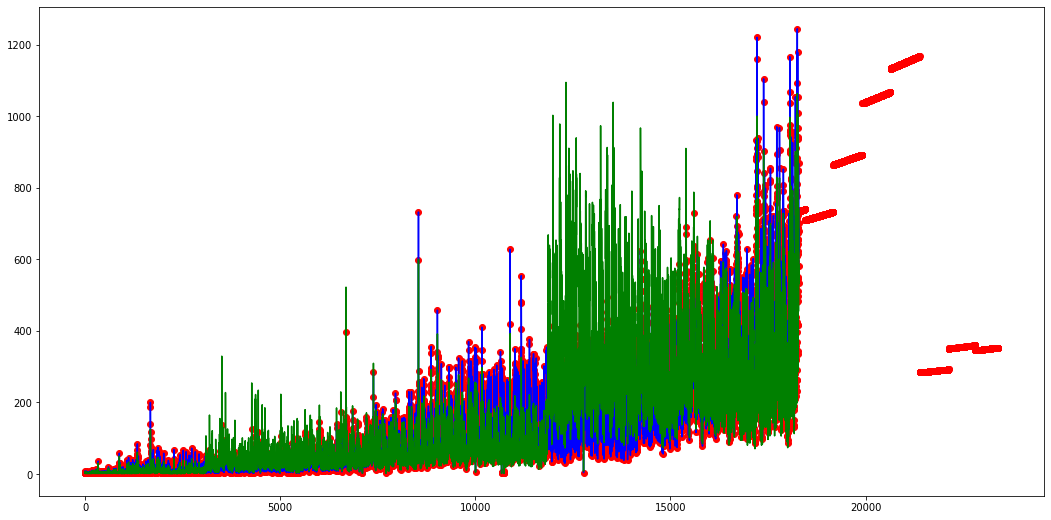

Regresssion Ending...


0       734.094269
1       734.127824
2       734.161378
3       734.194933
4       734.228488
           ...    
5107    352.994906
5108    353.007987
5109    353.021069
5110    353.034150
5111    353.047232
Name: Volume, Length: 5112, dtype: float64

In [49]:


#Regression model
def Regression(train,test): #data):
    print('Regresssion Starting...')
    
    ## Split the Date into Month, Quarter & Year ##
    ###############################################
    data = train.copy()
    
    data['Source'] = 'Train'
    data = pd.concat([data,test])
    data['Source'] = data['Source'].fillna('Test')

    data["Datetime"] = pd.to_datetime(data["Datetime"], dayfirst=True)
    data=data.sort_values(["Datetime"])
    data["Quarter"] = data["Datetime"].dt.quarter
    data["Year"] = data["Datetime"].dt.year
    data["Month"] = data["Datetime"].dt.month
    data["Day"] = data["Datetime"].dt.day
    data["DayofWeek"] = data["Datetime"].dt.dayofweek
    data["WeekofYear"] = data["Datetime"].dt.weekofyear
    data["Hour"] = data["Datetime"].dt.hour
    data["Minute"] = data["Datetime"].dt.minute
    data[['Datetime','Day','DayofWeek','WeekofYear','Month','Quarter','Year','Hour','Minute']]
    data.rename(columns={'Count': 'Volume'}, inplace=True)
    ## data.to_csv('EDA_data1.csv',index=False)
    
    Train = data[data['Source']=='Train']
    Test = data[data['Source']=='Test']
    display(Train.columns)
    
    ## Split the Data into Train(year<2019) & Test(year=2019) ##
    ############################################################    
    #Train=data[(data.Year>=2015)&(data.Year<2019)] #modify date according to your dataset; Train : 2017-2018
    #Test=data[(data.Year==2019)]  #modify date according to your dataset; Test : 2019
    
    ## compute seasoned_index by year ##
    Train["SI_Y"]=Train["Volume"]/Train.groupby("Year")["Volume"].transform(np.mean)
    
    ## compute seasoned_index by month ##
    Train["F_SI"]=Train.groupby("Month")["SI_Y"].transform(np.mean)
    
    ## compute seasoned_index by Trend ##
    Train["D_Seasonalised_trend"] = Train["Volume"]/Train["F_SI"]    
    
    ## compute level_index_1 using Q1 with preceding.Q4 ##
    ##Train["Level_index1"]=np.mean(Train[(Train.Year==2018)&(Train.Quarter==1)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2017)&(Train.Quarter==4)]["D_Seasonalised_trend"])
    Train["Level_index1"]=np.mean(Train[(Train.Year==2014)&(Train.Quarter==1)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2013)&(Train.Quarter==4)]["D_Seasonalised_trend"])
    
    ## compute level_index_2 using last Q4-Q3 with preceding.Q3-Q2 ##
    ##numer1=np.mean(Train[(Train.Year==2018)&(Train.Quarter==3)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2018)&(Train.Quarter==2)]["D_Seasonalised_trend"])
    ##numer2=np.mean(Train[(Train.Year==2018)&(Train.Quarter==4)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2018)&(Train.Quarter==3)]["D_Seasonalised_trend"])
    numer1=np.mean(Train[(Train.Year==2013)&(Train.Quarter==3)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2013)&(Train.Quarter==2)]["D_Seasonalised_trend"])
    numer2=np.mean(Train[(Train.Year==2013)&(Train.Quarter==4)]["D_Seasonalised_trend"])/np.mean(Train[(Train.Year==2013)&(Train.Quarter==3)]["D_Seasonalised_trend"])
    
    Train["Level_index2"]=np.mean([numer1,numer2])
    Train=Train.sort_values(["Datetime"])
    Train.index=range(len(Train))
    #Train["ID"]=range(1,(len(Train)+1))
    
    Train["Deleveled_series"]=np.where(Train.Year==2013, Train["D_Seasonalised_trend"]*Train["Level_index1"],Train["D_Seasonalised_trend"])
    
    lm = LinearRegression()
    #X = np.array(Train[["ID", "Variable_1"]]) # In case of no extra variable in the dataset, remove the extra variable name from the list, then append the line with ".reshape(-1, 1)"
    X = np.array(Train[["ID"]])
    Y = np.array(Train["Deleveled_series"]).reshape(-1,1)
    #Y = np.array(Train["Volume"]).reshape(-1,1)
    display(Train.head(3))
    #plt.plot(Train['ID'],Train['Volume'],"r--")
    #plt.show()
    model = lm.fit(X,Y)
    y_train_pred = lm.predict(X)
    y_train_pred = y_train_pred*Train.iloc[0]["Level_index2"]*np.array(Train.iloc[0:len(y_train_pred)]["F_SI"]).reshape(-1,1)
    y_train_act = Train[['Volume']]
    acc_scr =  np.mean(np.abs(lm.score(X,Y)))
    rmse_scr = np.mean(np.abs(mean_squared_error(np.array(y_train_act),np.array(y_train_pred),squared=False)))
    mape_scr = np.mean(np.abs((np.array(y_train_act) - np.array(y_train_pred)) / np.array(y_train_act))) * 100
    print('Coeff:',lm.coef_)
    print('Intercept:',lm.intercept_)
    print('MAPE:',mape_scr)
    print('RMSE:',rmse_scr)
    print('ACC:',acc_scr)
    # return(data)
    # zzz
    ### print(max(Train["ID"]))
    ### print(len(Test))
    ### print(range(len(Test)))
    ### Test["ID"]=range(len(Test))
    ### #Test["ID"]=Test["ID"]+max(Train["ID"])
    ### Test["ID"]=Test["ID"]+(max(Train["ID"])+1)
    display(Test.head(3))
    #X_test=np.array(Test[["ID", "Variable_1"]]) # In case of no extra variable in the dataset, remove the extra variable name from the list, then append the line with ".reshape(-1, 1)"
    X_test=np.array(Test[["ID"]])
    Y_test=model.predict(X_test)
    
    Pred1 = Y_test*Train.iloc[0]["Level_index2"]*np.array(Train.iloc[0:len(Y_test)]["F_SI"]).reshape(-1,1)
    ### Pred1 = Y_test*np.array(Train.iloc[0:len(Y_test)]["F_SI"]).reshape(-1,1)
    ### #Test["Predictions"]=Pred1
    ### Test["D_Seasonalised_trend"]=Pred1
    Test["Volume"]=Pred1
    
    submission['Count'] = Pred1
    #submission.to_csv('submission_lr_SI_TR_LI2_v1.csv', index=False)
    #293.390 Rnk#933

    display(Test.head(3))
    out = pd.concat([Train, Test], axis = 0)
    plt.figure(figsize=(18,9))
    plt.scatter(out['ID'],out['Volume'],color="red")
    plt.plot(Train['ID'],Train['Volume'],"b-")
    plt.plot(out['ID'],out['D_Seasonalised_trend'],"g-")
    plt.show()   
    #return(Test['Predictions'])
    print('Regresssion Ending...')
    return(Test['Volume'])
Regression(train,test)

# ARIMA model

In [50]:
#Arima model
def Arima(train,test): 
    train.rename(columns={'Count': 'Volume'}, inplace=True)
    test.rename(columns={'Count': 'Volume'}, inplace=True)
    train = train.drop(columns='ID')
    test = test.drop(columns='ID')
    print(train.info())
    train['Datetime'] = pd.to_datetime(train['Datetime'],format="%y-%m-%d %H:%M") 
    test['Datetime'] = pd.to_datetime(test['Datetime'],format="%y-%m-%d %H:%M") 
    
    #train = train.astype('float32')
    #test = test.astype('float32')
    display(train,test)
    X = train['Volume'].values
    #size = np.sum(data['Date']<='12/31/2018')
    #size = np.sum(train['Datetime'])
    #train, test = X[0:size], X[size:len(X)]
    history = [x for x in train['Volume'].values]
    predictions = list()  
    display('len(history)=',len(history))    
    display('len(test)=',len(test)) 
    display('range(len(test))=',range(len(test)))
    #test = test[:,1].values
    display('test.head=',test.head())
    display('test.shape=',test.shape)
    for t in range(len(test)):
        #print('t=',t)
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        #obs = test[t]
        #history.append(obs)
    display('predict=',predictions)
    return predictions  
#Arima(train,test)